In [1]:
import os
os.environ["WEBBPSF_PATH"] = 'webbpsf-data'
os.environ["WEBBPSF_EXT_PATH"] = 'webbpsf-data'
os.environ["PYSYN_CDBS"] = "cdbs"

from astropy.io import fits

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.3'

jax.config.update("jax_enable_x64", True)

#### Loading Files

In [2]:
import pandas as pd

image_data = pd.read_csv('statistical_analysis/image_info_filt.csv')
image_data.set_index("Name", inplace=True)
image_data.columns = ["Radius", "Inclination", "Position Angle", "Distance", "Knots"]
print(image_data)

                Radius  Inclination  Position Angle  Distance  Knots
Name                                                                
hd145560_H_pol    85.3         43.9           221.5    120.44      7
hd146897_H_pol    85.0         84.0           293.9    131.50      9
ceant_H_pol       29.8         13.1           271.0     34.03      7
hd111520_H_pol    81.0         88.0           165.0    108.94      7
hd115600_H_pol    46.0         80.0            27.5    109.62      7
hd129590_H_pol    66.9         75.7           121.7    136.04      9
hd117214_H_pol    60.2         71.0           359.8    107.61     11
hd35841_H_pol     60.3         84.9           345.8    103.68      7
hd30447_H_pol     83.0         83.0            32.3     80.54      7
hd32297_H_pol     98.4         88.4            47.9    132.79     13
hd110058_H_pol    39.0         84.0           335.0    129.98      5
hd111161_H_pol    72.4         62.1           263.2    109.43      7
hd157587_H_pol    79.0         70.

### Processing Fits File

/home/mihirkondapalli/anaconda3/envs/jwst_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


webbpsf_ext log messages of level WARN and above will be shown.
webbpsf_ext log outputs will be directed to the screen.
Could not import CuPy. Setting: use_gpu=False (i.e., using CPU operations).
Filename: Fits/hd117214_H_pol.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     496   ()      
  1  SCI           1 ImageHDU       138   (281, 281, 4)   float32   
  2  DQ            3 ImageHDU        64   (281, 281, 2)   uint8   


Text(0.5, 1.0, 'Image from Fits File')

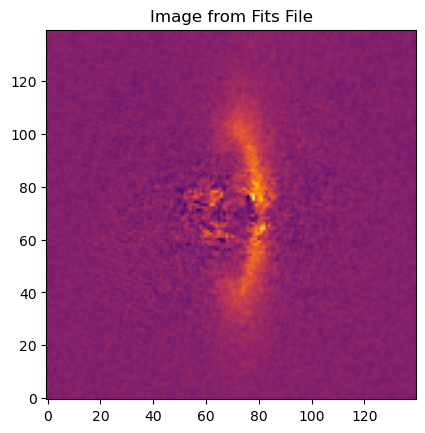

In [3]:
from statistical_analysis.optimize_framework import OptimizeUtils

name = "hd117214_H_pol"
fits_image_filepath = "Fits/" + str(name) + ".fits"
hdul = fits.open(fits_image_filepath)
row = image_data.loc[name]

#Displays File Info
hdul.info()

# Gets Image
target_image = OptimizeUtils.process_image(hdul['SCI'].data[1,:,:])

# Displays Image
plt.imshow(target_image, origin='lower', cmap='inferno')
plt.title("Image from Fits File")

## Getting Optimal Disk Fit

In [4]:
from statistical_analysis.optimize_framework import Optimizer, OptimizeUtils
from utils.objective_functions import objective_model, objective_ll, objective_fit, Parameter_Index
from utils.SLD_ojax import ScatteredLightDisk
from utils.SLD_utils import *

### Getting Optimal Fit

In [5]:

target_image = OptimizeUtils.process_image(hdul['SCI'].data[1,:,:])
err_map = OptimizeUtils.process_image(OptimizeUtils.create_empirical_err_map(hdul['SCI'].data[2,:,:])) #, outlier_pixels=[(57, 68)]))

In [6]:
start_disk_params = Parameter_Index.disk_params.copy()
start_spf_params = InterpolatedUnivariateSpline_SPF.params.copy()
start_psf_params = EMP_PSF.params.copy()
start_misc_params = Parameter_Index.misc_params.copy()

start_disk_params = Parameter_Index.disk_params.copy()
start_disk_params['sma'] = row["Radius"]
start_disk_params['inclination'] = row["Inclination"]
start_disk_params['position_angle'] = row["Position Angle"]

start_spf_params['num_knots'] = 6 # int(row["Knots"])

start_misc_params['distance'] = row["Distance"]

opt = Optimizer(start_disk_params, start_spf_params, start_psf_params, start_misc_params, 
                ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, EMP_PSF)

opt.inc_bound_knots()

print(f"{opt.spf_params['knot_values']}, {opt.misc_params['flux_scaling']}")
opt.scale_knots(target_image)
print(f"{opt.spf_params['knot_values']}, {opt.misc_params['flux_scaling']}")

print(opt.log_likelihood(target_image, err_map))

[1. 1. 1. 1. 1. 1.], 1000000.0
[0.00956708 0.00284962 0.00147099 0.00093107 0.00065611 0.0004941 ], 1000000.0
-51687.27076308291


Text(0.5, 1.0, 'Initial Guess, Log-Likelihood: -51687.27076308291')

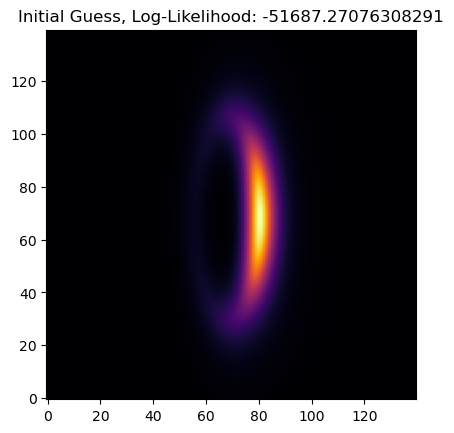

In [7]:
plt.imshow(opt.model(), origin='lower', cmap='inferno')
plt.title("Initial Guess, Log-Likelihood: " + str(opt.log_likelihood(target_image, err_map)))

In [8]:
opt.print_params()

Disk Params: {'accuracy': 0.005, 'alpha_in': 5, 'alpha_out': -5, 'sma': np.float64(60.2), 'e': 0.0, 'ksi0': 3.0, 'gamma': 2.0, 'beta': 1.0, 'amin': 0.0, 'dens_at_r0': 1.0, 'inclination': np.float64(71.0), 'position_angle': np.float64(359.8), 'x_center': 70.0, 'y_center': 70.0, 'halfNbSlices': 25, 'omega': 0.0}
SPF Params: {'low_bound': Array(-0.94551858, dtype=float64), 'up_bound': Array(0.94551858, dtype=float64), 'num_knots': 6, 'knot_values': Array([0.00956708, 0.00284962, 0.00147099, 0.00093107, 0.00065611,
       0.0004941 ], dtype=float64)}
PSF Params: {'scale_factor': 1, 'offset': 1}
Misc Params: {'distance': np.float64(107.61), 'pxInArcsec': 0.01414, 'nx': 140, 'ny': 140, 'halfNbSlices': 25, 'flux_scaling': 1000000.0}


In [9]:
# Running optimization method
fit_keys = ['alpha_in', 'alpha_out', 'sma', 'inclination', 'position_angle', 'x_center', 'y_center', 'knot_values', 'flux_scaling']
opt.scipy_optimize(fit_keys, target_image, err_map, disp_soln=True, iters = 1000)
optimal_image = opt.model()

         Current function value: 46368.908039
         Iterations: 37
         Function evaluations: 1437
         Gradient evaluations: 95
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 46368.90803943804
        x: [ 1.162e+01 -2.696e+00 ...  8.710e-04  1.000e+06]
      nit: 37
      jac: [-6.348e-03  2.031e-01 ... -1.569e+01  0.000e+00]
 hess_inv: [[ 1.398e+00  2.035e-02 ...  7.878e-05  0.000e+00]
            [ 2.035e-02  1.812e-03 ... -6.300e-08  0.000e+00]
            ...
            [ 7.878e-05 -6.300e-08 ...  3.849e-08  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
     nfev: 1437
     njev: 95


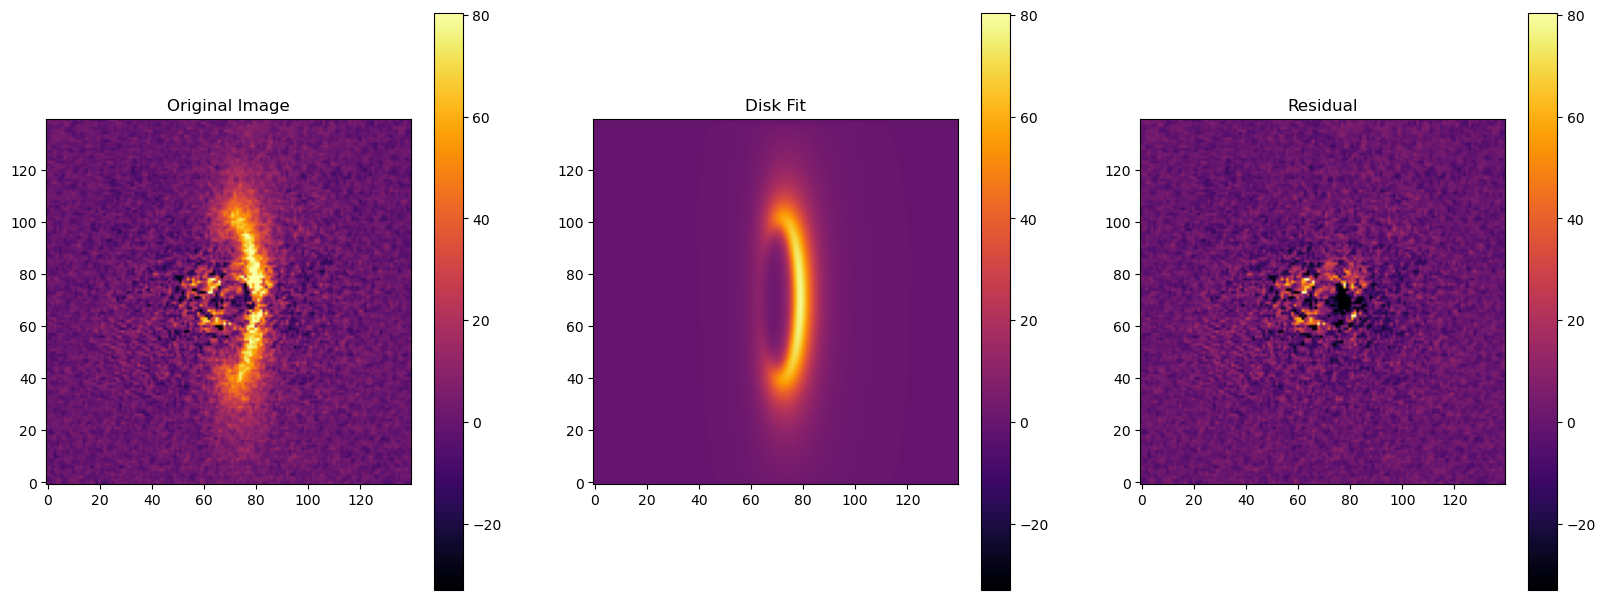

In [10]:
fig, axes = plt.subplots(1,3, figsize=(20,10))

mask = OptimizeUtils.get_mask(target_image)
vmin = np.nanpercentile(target_image[mask], 1)
vmax = np.nanpercentile(target_image[mask], 99)

im = axes[0].imshow(target_image, origin='lower', cmap='inferno')
axes[0].set_title("Original Image")
plt.colorbar(im, ax=axes[0], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[1].imshow(optimal_image, origin='lower', cmap='inferno')
axes[1].set_title("Disk Fit")
plt.colorbar(im, ax=axes[1], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[2].imshow(target_image-optimal_image, origin='lower', cmap='inferno')
axes[2].set_title("Residual")
plt.colorbar(im, ax=axes[2], shrink=0.75)
im.set_clim(vmin, vmax)

In [11]:
opt.scale_spline_to_fixed_point(0, 1)
opt.print_params()

Disk Params: {'accuracy': 0.005, 'alpha_in': np.float64(11.616277340686993), 'alpha_out': np.float64(-2.6963255786459537), 'sma': np.float64(46.03947929790446), 'e': 0.0, 'ksi0': 3.0, 'gamma': 2.0, 'beta': 1.0, 'amin': 0.0, 'dens_at_r0': 1.0, 'inclination': np.float64(76.18591104960008), 'position_angle': np.float64(359.7998832081873), 'x_center': np.float64(72.93167532717202), 'y_center': np.float64(72.62611947787299), 'halfNbSlices': 25, 'omega': 0.0}
SPF Params: {'low_bound': Array(-0.94551858, dtype=float64), 'up_bound': Array(0.94551858, dtype=float64), 'num_knots': 6, 'knot_values': Array([2.71534647, 1.71553708, 1.10691751, 0.92863228, 0.62452675,
       0.334324  ], dtype=float64)}
PSF Params: {'scale_factor': 1, 'offset': 1}
Misc Params: {'distance': np.float64(107.61), 'pxInArcsec': 0.01414, 'nx': 140, 'ny': 140, 'halfNbSlices': 25, 'flux_scaling': Array(2605.33952819, dtype=float64)}


## Running MCMC

In [17]:
# For MCMC, spline values are log scaled, they are passed in as log(spf_params) and are exponated in the lambda expression, this evens out the markov chains
# helping MCMC work better

fit_keys = ['alpha_in', 'alpha_out', 'sma', 'inclination', 'position_angle', 'x_center', 'y_center', 'knot_values', 'flux_scaling']

spline_lb = np.log(0.1)
spline_ub = np.log(5)
bounds = [np.array([0.1, -15, 0, 0, 0, 65, 65, spline_lb, spline_lb, spline_lb, spline_lb, spline_lb, spline_lb, 0]),
          np.array([15, -0.1, 150, 180, 400, 75, 75, spline_ub, spline_ub, spline_ub, spline_ub, spline_ub, spline_ub, 5e3])]

mc_model = opt.mcmc(fit_keys, target_image, err_map, bounds, nwalkers=100, niter=100, burns=20)

Running burn-in...


100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


Running production...


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


In [ ]:
mc_soln = np.median(mc_model.sampler.flatchain, axis=0)
img = opt.model()

Text(0.5, 1.0, 'Post MCMC')

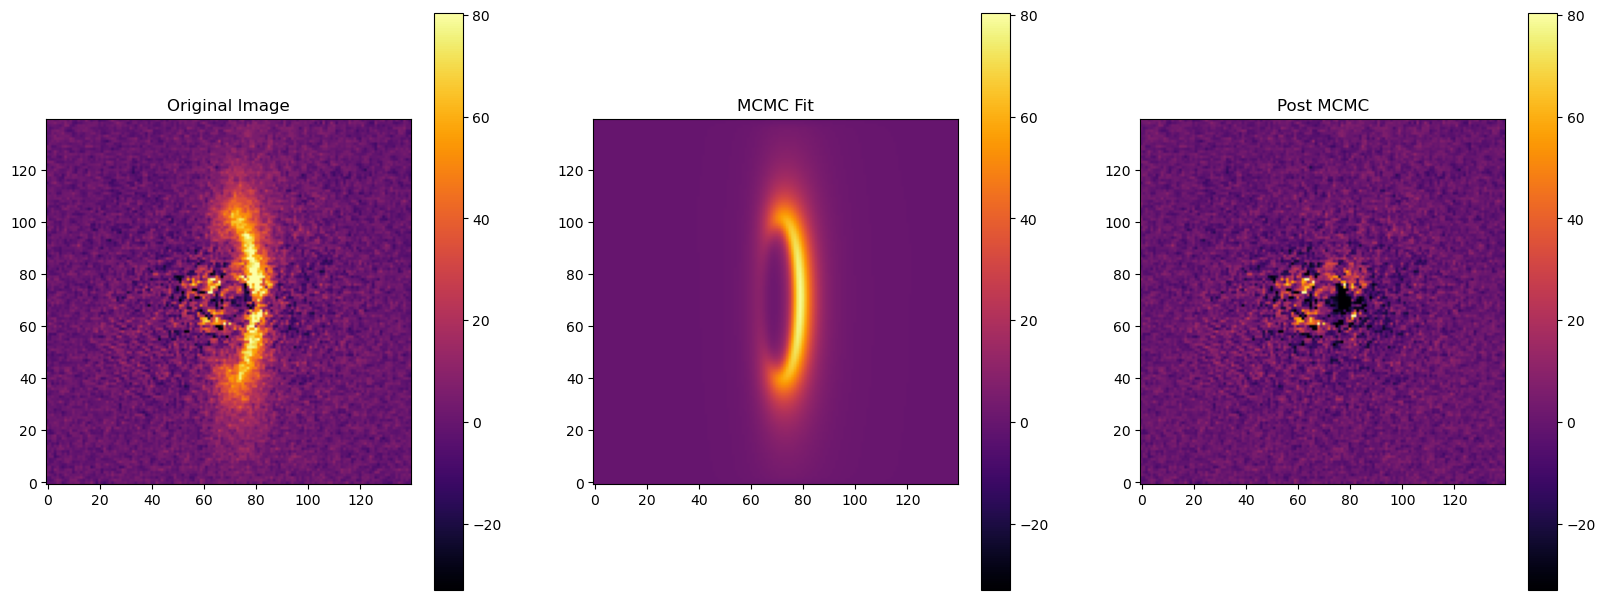

In [22]:
fig, axes = plt.subplots(1,3, figsize=(20,10))

mask = OptimizeUtils.get_mask(target_image)
vmin = np.nanpercentile(target_image[mask], 1)
vmax = np.nanpercentile(target_image[mask], 99)

im = axes[0].imshow(target_image, origin='lower', cmap='inferno')
axes[0].set_title("Original Image")
plt.colorbar(im, ax=axes[0], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[1].imshow(img, origin='lower', cmap='inferno')
axes[1].set_title("MCMC Fit")
plt.colorbar(im, ax=axes[1], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[2].imshow(target_image-img, origin='lower', cmap='inferno')
axes[2].set_title("Residual")
plt.colorbar(im, ax=axes[2], shrink=0.75)
im.set_clim(vmin, vmax)
plt.title("Post MCMC")

### Plotting MCMC Results

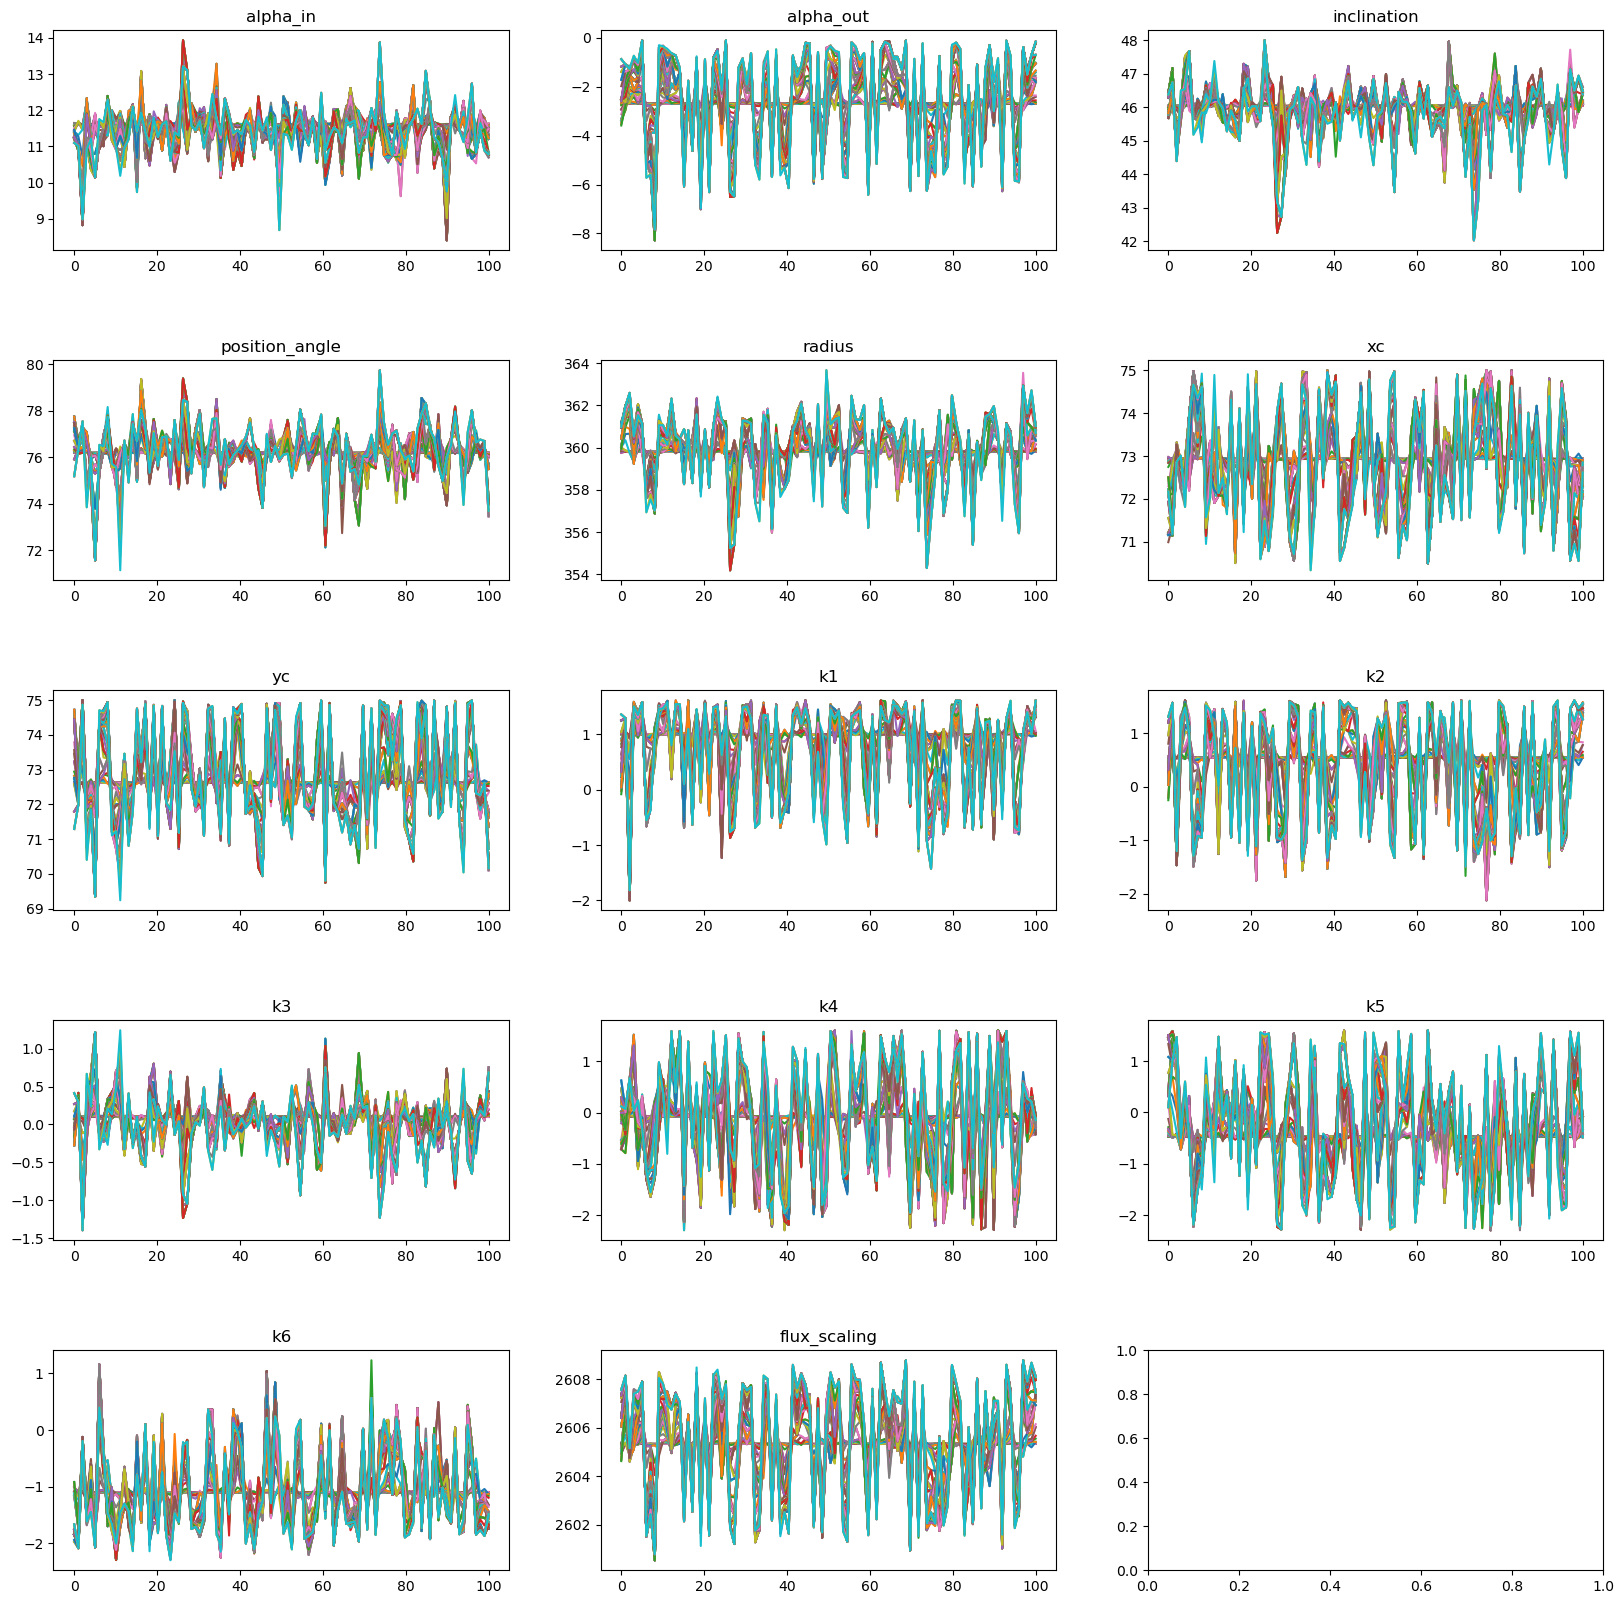

In [20]:
labels = ['alpha_in', 'alpha_out', 'inclination', 'position_angle', 'radius', 'xc', 'yc']
for i in range(0, opt.spf_params['num_knots']):
    labels.append('k'+str(i+1))
labels.append('flux_scaling')
mc_model.plot_chains(labels)

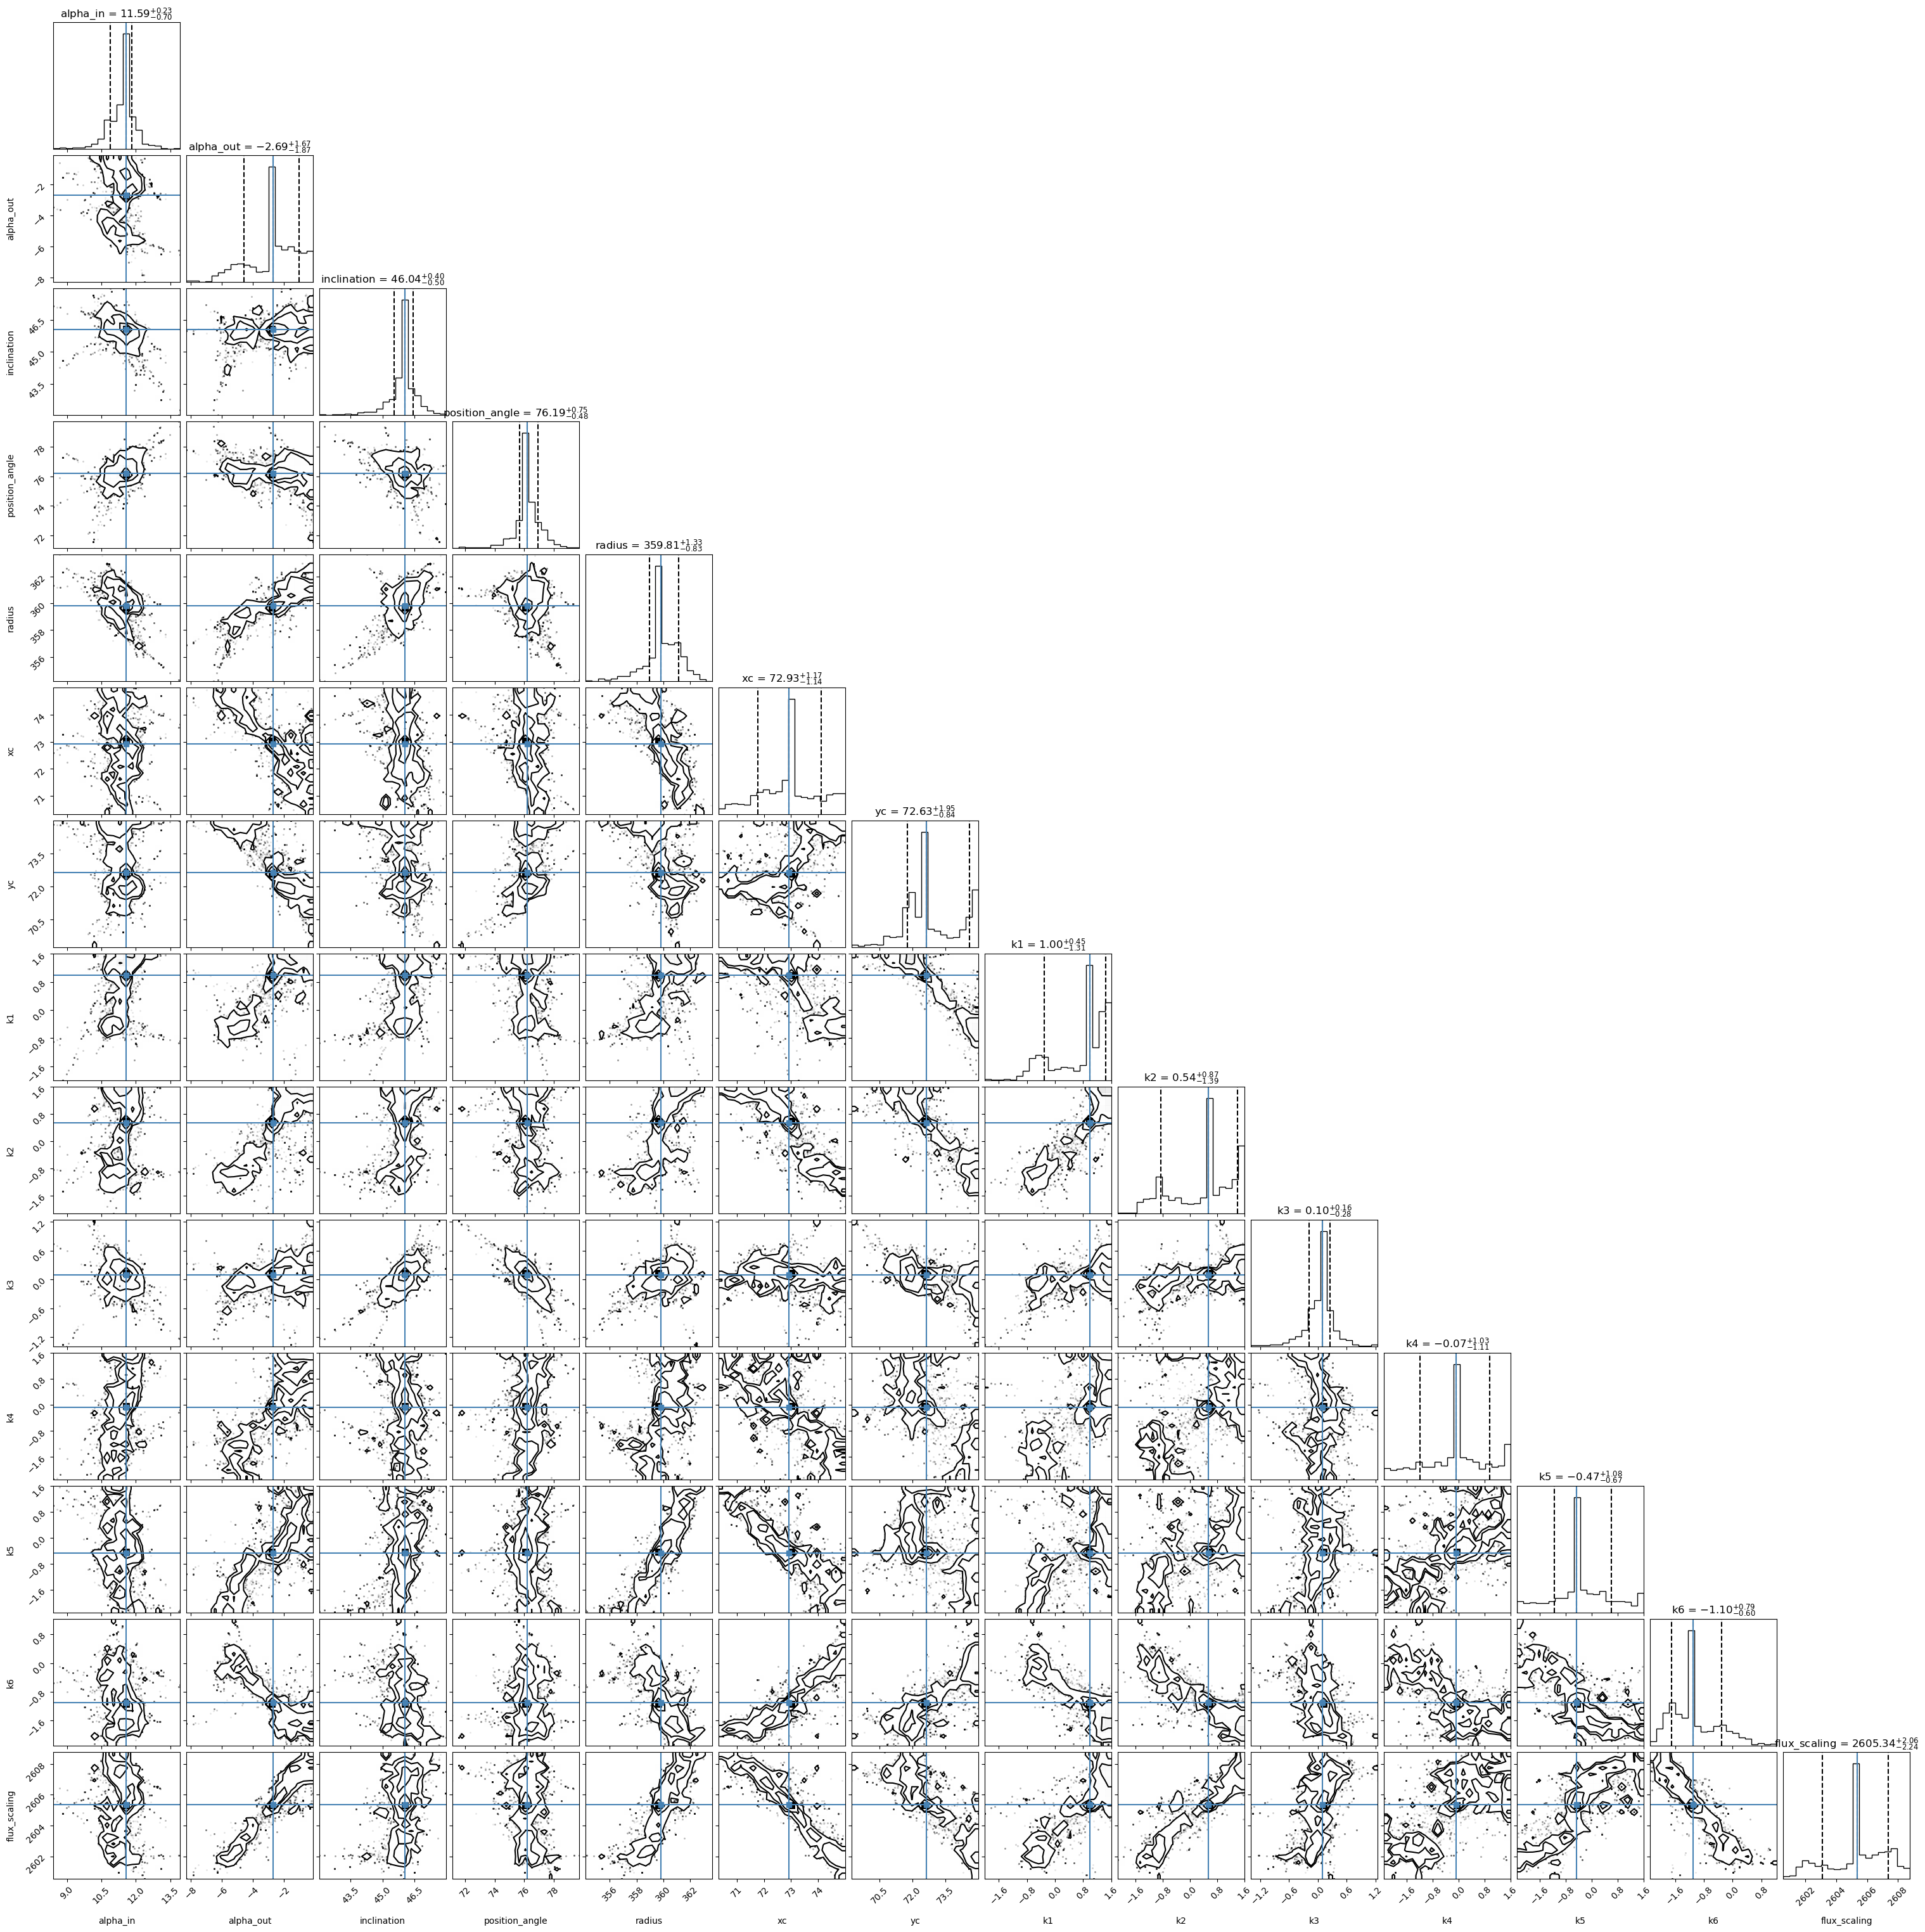

In [21]:
mc_model.show_corner_plot(labels, truths=mc_soln)